# Visualize Decima predictions for an example sc-eQTL variant

In [1]:
import sys
import numpy as np
import pandas as pd
import os
import anndata
import torch

from scipy.ndimage import gaussian_filter1d
from grelu.visualize import plot_attributions, plot_tracks, add_highlights
from captum.attr import InputXGradient
from grelu.transforms.prediction_transforms import Aggregate
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

sys.path.append('/code/decima/src/decima/')
from interpret import extract_gene_data
from lightning import LightningModel

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Paths

In [2]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823"
matrix_file = os.path.join(save_dir, "data.h5ad")
h5_file = os.path.join(save_dir, "data.h5")
eqtl_ad_file = 'scored_sceqtl_vars.h5ad'

## Load

In [3]:
ad = anndata.read_h5ad(matrix_file)
eqtl_ad = anndata.read_h5ad(eqtl_ad_file)

In [4]:
ckpts=[
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/kugrjb50/checkpoints/epoch=3-step=2920.ckpt',
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/i68hdsdk/checkpoints/epoch=2-step=2190.ckpt',
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/0as9e8of/checkpoints/epoch=7-step=5840.ckpt',
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/i9zsp4nm/checkpoints/epoch=8-step=6570.ckpt',
]
models = [LightningModel.load_from_checkpoint(ckpt).eval() for ckpt in ckpts]

/opt/conda/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
wandb: Currently logged in as: anony-mouse-525326028787943229

In [5]:
from eqtl_meta import cell_type_mapping
cell_type_mapping = pd.read_table(StringIO(cell_type_mapping))
all_modelcelltypes = set(cell_type_mapping['model_celltype'])

## Subset to matched cell types

In [6]:
gene = 'JAZF1'
rsid = 'rs2158799'
for gene in ['CEBPA', 'JAZF1']:
    eqtl_ad.var[gene] = np.array(ad[:, gene].X).squeeze()

In [7]:
ad = ad[(ad.obs.organ=='blood') & (ad.obs.cell_type.isin(all_modelcelltypes))]
eqtl_ad = eqtl_ad[(eqtl_ad.obs.gene_symbol==gene) & (eqtl_ad.obs.rsid==rsid), 
                (eqtl_ad.var.organ=='blood') & (eqtl_ad.var.cell_type.isin(all_modelcelltypes))]

print(ad.shape, eqtl_ad.shape)

(697, 18457) (1, 697)


In [8]:
eqtl_ad.var['effect'] = np.array(eqtl_ad.X).squeeze()
eqtl_ad.var['is_mono'] = eqtl_ad.var.cell_type.str.contains('monocyte')

/tmp/ipykernel_18300/2216509452.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


## Visualize predictions

In [9]:
eqtl_ad.var.cell_type = eqtl_ad.var.cell_type.astype(str)
eqtl_ad.var.loc[eqtl_ad.var.cell_type == 'CD4-positive, alpha-beta T cell', 'cell_type'] = 'CD4+ alpha-beta T cell'
eqtl_ad.var.loc[eqtl_ad.var.cell_type == 'CD8-positive, alpha-beta T cell', 'cell_type'] = 'CD8+ alpha-beta T cell'
eqtl_ad.var.cell_type = eqtl_ad.var.cell_type.apply(lambda x:x[0].upper() + x[1:])
eqtl_ad.var.cell_type = pd.Categorical(eqtl_ad.var.cell_type,
        categories = eqtl_ad.var.groupby('cell_type').effect.mean().sort_values().index.tolist())

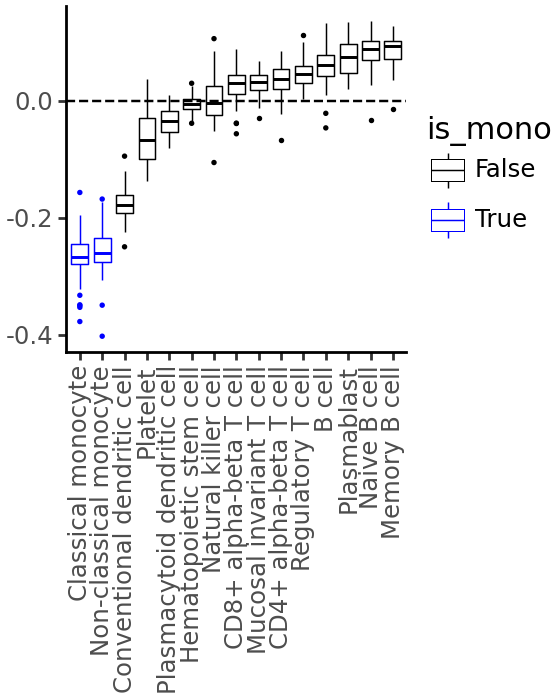

In [10]:
(
    ggplot(eqtl_ad.var, aes(x='cell_type', y='effect', color='is_mono')) + geom_boxplot(outlier_size=0.1, size=.3)
    + theme_classic() + theme(figure_size=(2.8, 3.5)) + scale_color_manual(values=['black', 'blue'])
    + theme(axis_text_x=element_text(rotation=90, hjust=.5)) + ylab("") + xlab("")
    + geom_hline(yintercept=0, linetype='--')
)

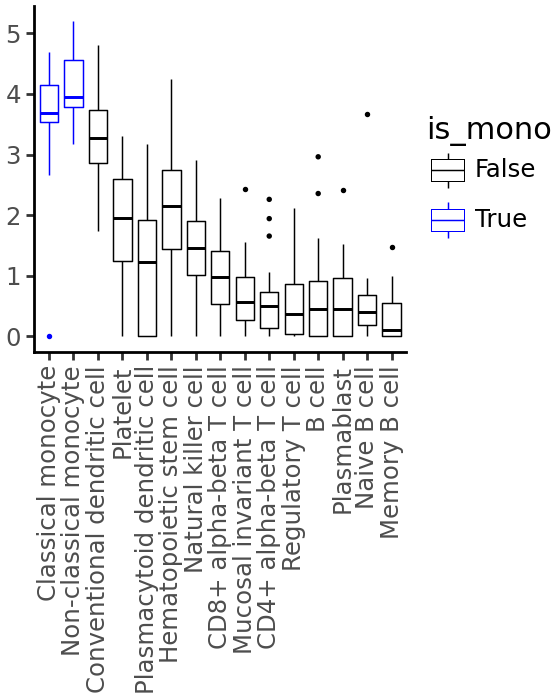

In [11]:
(
    ggplot(eqtl_ad.var, aes(x='cell_type', y='CEBPA', color='is_mono')) + geom_boxplot(outlier_size=0.1, size=.3)
    + theme_classic() + theme(figure_size=(2.8,3.5)) + scale_color_manual(values=['black', 'blue'])
    + theme(axis_text_x=element_text(rotation=90, hjust=.5)) + ylab("") + xlab("")
)

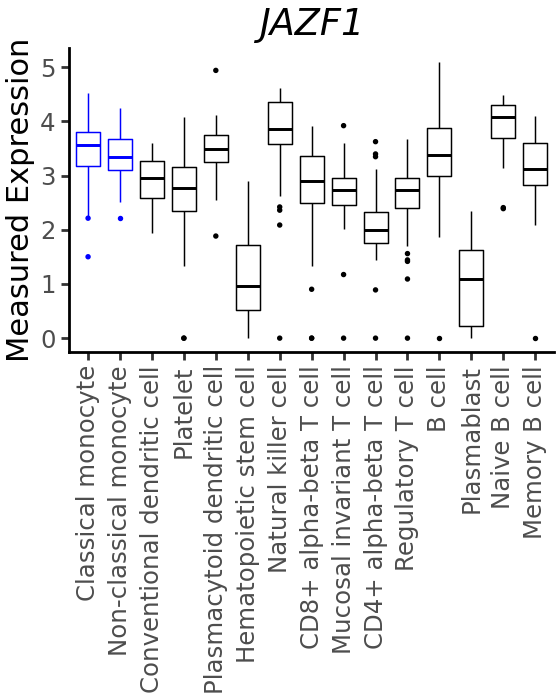

In [12]:
(
    ggplot(eqtl_ad.var, aes(x='cell_type', y='JAZF1', color='is_mono')) + geom_boxplot(outlier_size=0.1, size=.3)
    + theme_classic() + theme(figure_size=(2.8,3.5)) + scale_color_manual(values=['black', 'blue'])
    + theme(axis_text_x=element_text(rotation=90, hjust=.5)) + ylab("Measured Expression") + xlab("")
    + ggtitle('JAZF1') + theme(plot_title = element_text(face = "italic")) + theme(legend_position='none')
)

## Extract inputs

In [13]:
seq, mask = extract_gene_data(h5_file, gene, merge=False)
tss_pos = np.where(mask[0] == 1)[0][0] - 2
device = torch.device(0)

In [14]:
print(seq[:, 107147])

ref_seq = seq.clone()
alt_seq = seq.clone()
alt_seq[2, 107147] = 0
alt_seq[1, 107147] = 1
print(ref_seq[:, 107147])
print(alt_seq[:, 107147])

ref_inputs = torch.vstack([ref_seq, mask]).to(device)
alt_inputs = torch.vstack([alt_seq, mask]).to(device)

tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])


## Attributions in monocytes

In [15]:
%%time
on_tasks = ad.obs_names[ad.obs.cell_type.str.contains('monocyte')].tolist()

attr_ref_on = []
attr_alt_on = []

for model in models:
    model.add_transform(Aggregate(tasks=on_tasks, task_aggfunc="mean", model=model))
    attributer = InputXGradient(model.to(device))
    with torch.no_grad():
        attr_ref_on.append(attributer.attribute(ref_inputs).cpu().numpy())
        attr_alt_on.append(attributer.attribute(alt_inputs).cpu().numpy())

attr_ref_on = np.stack(attr_ref_on).mean(0)
attr_alt_on = np.stack(attr_alt_on).mean(0)

/opt/conda/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


CPU times: user 4.88 s, sys: 314 ms, total: 5.19 s
Wall time: 5.23 s


(0.0, 0.021)

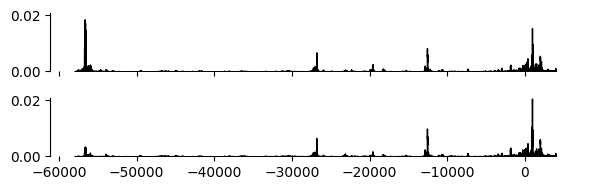

In [16]:
st = -58000
en = 4000
a_r_on = gaussian_filter1d(np.abs(attr_ref_on.mean(0)[tss_pos+st:tss_pos+en]), 5)
a_a_on = gaussian_filter1d(np.abs(attr_alt_on.mean(0)[tss_pos+st:tss_pos+en]), 5)
fig, axes = plt.subplots(2, 1, figsize=(6, 2), sharex=True, tight_layout=True)
axes[0].fill_between(np.linspace(st, en, num=en-st), a_r_on, color="black")
sns.despine(top=True, right=True, bottom=True)
axes[0].set_ylim(0, 0.021)
axes[1].fill_between(np.linspace(st, en, num=en-st), a_a_on, color="black")
sns.despine(top=True, right=True, bottom=True)
axes[1].set_ylim(0, 0.021)

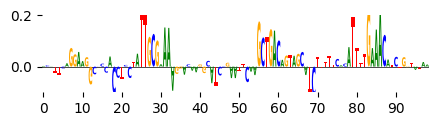

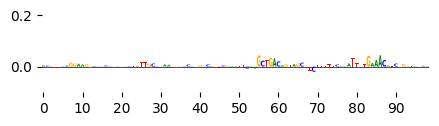

In [17]:
display(plot_attributions(attr_ref_on[:-1, tss_pos-56720:tss_pos-56620], ylim=(-.1, .2), figsize=(5,1)))
display(plot_attributions(attr_alt_on[:-1, tss_pos-56720:tss_pos-56620], ylim=(-.1, .2), figsize=(5,1)))

## Attributions in off-target cell types

In [18]:
%%time
off_tasks = ad.obs_names[ad.obs.cell_type == 'natural killer cell'].tolist()

attr_ref_off = []
attr_alt_off = []

for model in models:
    model.add_transform(Aggregate(tasks=off_tasks, task_aggfunc="mean", model=model))
    attributer = InputXGradient(model.to(device))
    with torch.no_grad():
        attr_ref_off.append(attributer.attribute(ref_inputs).cpu().numpy())
        attr_alt_off.append(attributer.attribute(alt_inputs).cpu().numpy())

attr_ref_off = np.stack(attr_ref_off).mean(0)
attr_alt_off = np.stack(attr_alt_off).mean(0)

/opt/conda/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


CPU times: user 4.26 s, sys: 56.2 ms, total: 4.31 s
Wall time: 4.31 s


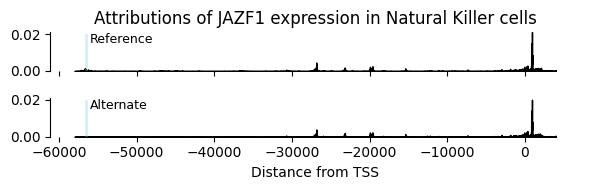

In [19]:
st = -58000
en = 4000
a_r_off = gaussian_filter1d(np.abs(attr_ref_off.mean(0)[tss_pos+st:tss_pos+en]), 5)
a_a_off = gaussian_filter1d(np.abs(attr_alt_off.mean(0)[tss_pos+st:tss_pos+en]), 5)
fig, axes = plt.subplots(2, 1, figsize=(6, 2), sharex=True, tight_layout=True)
axes[0].fill_between(np.linspace(st, en, num=en-st), a_r_off, color="black")
sns.despine(top=True, right=True, bottom=True)
axes[0].set_ylim(0, 0.021)
axes[0].set_title('Attributions of JAZF1 expression in Natural Killer cells', fontsize=12)
axes[0].text(-56000, 0.015, 'Reference', fontsize=9)
add_highlights(axes[0], starts=-56600, ends=-56300, ymin=0, ymax=0.02, facecolor='skyblue', alpha=.3)
axes[1].fill_between(np.linspace(st, en, num=en-st), a_a_off, color="black")
sns.despine(top=True, right=True, bottom=True)
axes[1].set_ylim(0, 0.021)
axes[1].text(-56000, 0.015, 'Alternate', fontsize=9)
axes[1].set_xlabel('Distance from TSS')
add_highlights(axes[1], starts=-56600, ends=-56300, ymin=0, ymax=0.02, facecolor='skyblue', alpha=.3)

## Control variants

In [31]:
eqtl_ad_all = anndata.read_h5ad(eqtl_ad_file)
eqtl_ad_all = eqtl_ad_all[(eqtl_ad_all.obs.gene_symbol=='JAZF1'), (eqtl_ad_all.var.organ=='blood') & (eqtl_ad_all.var.cell_type.isin(all_modelcelltypes))]
eqtl_ad_all.var.cell_type = eqtl_ad_all.var.cell_type.astype(str)
eqtl_ad_all.var.loc[eqtl_ad_all.var.cell_type == 'CD4-positive, alpha-beta T cell', 'cell_type'] = 'CD4+ alpha-beta T cell'
eqtl_ad_all.var.loc[eqtl_ad_all.var.cell_type == 'CD8-positive, alpha-beta T cell', 'cell_type'] = 'CD8+ alpha-beta T cell'
eqtl_ad_all.var.cell_type = eqtl_ad_all.var.cell_type.apply(lambda x:x[0].upper() + x[1:])

/opt/conda/lib/python3.11/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


In [32]:
eqtl_ad_all.shape

(21, 697)

In [33]:
sel_negatives = (eqtl_ad_all.obs.pos - 28180795).abs().sort_values()[:20].index.tolist()
eqtl_ad_all = eqtl_ad_all[sel_negatives]
eqtl_ad_all.shape

(20, 697)

In [35]:
eqtl_all = pd.DataFrame(eqtl_ad_all.X, columns=eqtl_ad.var.cell_type.tolist(), 
                        index=eqtl_ad_all.obs.variant.tolist()).reset_index().melt(id_vars='index')
eqtl_all.columns = ['variant', 'cell_type', 'effect']

In [23]:
eqtl_all.cell_type = pd.Categorical(eqtl_all.cell_type,
        categories = eqtl_ad.var.groupby('cell_type').effect.mean().sort_values().index.tolist())

/tmp/ipykernel_18300/2846255313.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


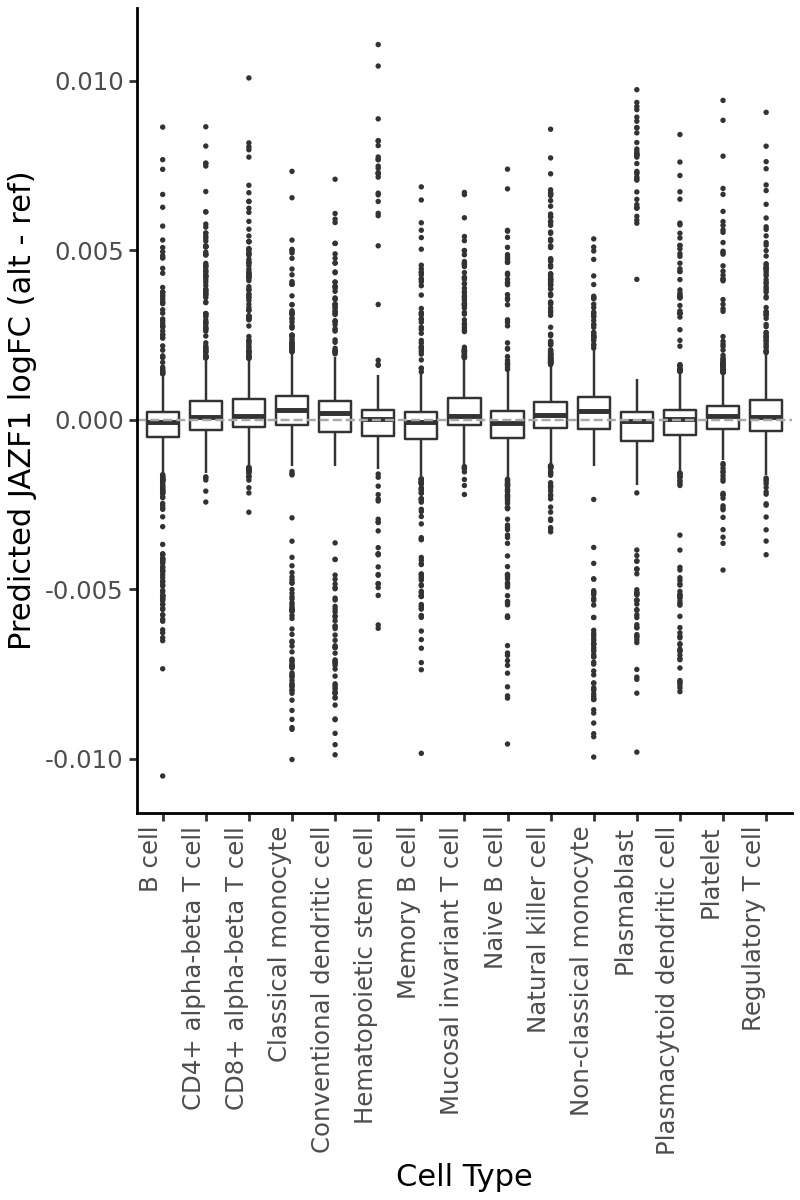

In [38]:
(
    ggplot(eqtl_all, aes(x='cell_type', y='effect')) 
    + geom_boxplot(outlier_size=0.1)
    + theme_classic() + theme(figure_size=(4,6))
    + theme(axis_text_x=element_text(rotation=90, hjust=1)) + ylab("Predicted JAZF1 logFC (alt - ref)") + xlab("Cell Type")
    + geom_hline(yintercept=0, linetype='--', color='darkgray')
)